In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
import optuna
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import matplotlib_fontja
import xgboost as xgb

c:\Users\takumi_inoue\projects\github\TakumiInoue0628\manufacturing-dx-purchase-prediction\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


データの読み込み

In [2]:
# データの読み込み
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
sample_submit = pd.read_csv("data/sample_submit.csv", header=None)

In [3]:
# アンケートデータ分析
def analyze_survey_data(df, survey_column, target_column, figsize=(5, 3)):
    category_counts = df[survey_column].value_counts().sort_index()
    plt.figure(figsize=figsize)
    bars = plt.bar(category_counts.index, category_counts.values)
    for bar in bars:
        height = bar.get_height()
        plt.text(
            x=bar.get_x() + bar.get_width() / 2,  # X座標 (棒の中央)
            y=height,                            # Y座標 (棒の高さ)
            s=f'{height}',                       # 表示するテキスト (整数で表示)
            ha='center',                         # 水平方向の位置揃え (中央)
            va='bottom'                          # 垂直方向の位置揃え (棒の下端に合わせる)
        )
    plt.xlabel(str(survey_column)+' 選択肢')
    plt.ylabel('回答数')
    plt.xticks(category_counts.index)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    average_purchase_by_survey = train.groupby(survey_column)[target_column].mean()
    plt.figure(figsize=figsize)
    bars = plt.bar(average_purchase_by_survey.index, average_purchase_by_survey.values)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.3f}', va='bottom', ha='center')
    plt.xlabel(str(survey_column)+' 選択肢')
    plt.ylabel(str(target_column)+' 割合')
    plt.xticks(average_purchase_by_survey.index) # X軸の目盛りをカテゴリ名に設定
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

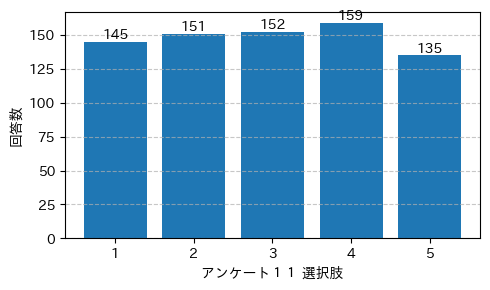

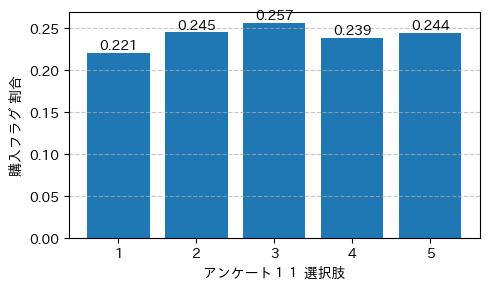

In [4]:
analyze_survey_data(train, 'アンケート１１', '購入フラグ', figsize=(5, 3))

データの前処理

In [5]:
# 特徴量エンジニアリング関数
def feature_engineering(df):
    # 財務指標の作成 (分母が0になる可能性を考慮)
    df['自己資本比率'] = df['自己資本'] / (df['総資産'] + 1e-6)
    df['売上高営業利益率'] = df['営業利益'] / (df['売上'] + 1e-6)
    df['総資産回転率'] = df['売上'] / (df['総資産'] + 1e-6)
    df['負債比率'] = df['負債'] / (df['自己資本'] + 1e-6)
    df['従業員数_x_売上高営業利益率'] = df['従業員数'] * df['売上高営業利益率']
    return df

# カテゴリ変数のエンコード関数
def encode_categorical(df, categorical_cols):
    encoders = {}
    for col in categorical_cols:
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col].astype(str))
        encoders[col] = encoder
    df = df.drop(columns=categorical_cols)
    return df, encoders

# 組織図を特徴量化する関数
def org_chart_features(df, keyword_features = {
    'dx_it': r'DX|デジタル|IT|情報システム',
    'planning': r'経営企画|経営戦略|事業企画',
    'quality': r'品質管理|品質保証|プロセス改善|業務改革',
    'rd': r'R&D|研究開発|新技術',
    'risk': r'リスク管理|内部監査|コンプライアンス',
    'mfg': r'製造|工場|生産技術' # 製造業向け商材のため
}):
    df = df.fillna('')
    org_df = pd.DataFrame()
    # 組織の規模（行数）
    org_df[df.name + '_line_count'] = df.apply(lambda x: len(x.split('\n')))
    # 組織単位数を（├, └, ┌の数）
    org_df[df.name + '_unit_count']= df.str.count(r'[├└┌]')
    # 特定部門の有無
    for col_name, pattern in keyword_features.items():
        org_df[df.name + "_has_" + col_name] = df.str.contains(pattern, case=False, na=False).astype(int)
    return org_df

# テキストデータの特徴量化関数（文章量）
def text_length_features(df):
    df = df.fillna('')
    length = [len(text) for text in df]
    length_df = pd.DataFrame(length, index=df.index, columns=[df.name + "_length"])
    return length_df

# テキストデータの特徴量化関数（ポジネガ出現率）
def pos_neg_ratio(df, positive_words, negative_words):
    df = df.fillna('')
    pos_neg_features = []
    for text in df:
        pos_count = sum(text.count(word) for word in positive_words)
        neg_count = sum(text.count(word) for word in negative_words)
        total_count = len(text.split())
        pos_ratio = pos_count / total_count if total_count > 0 else 0
        neg_ratio = neg_count / total_count if total_count > 0 else 0
        pos_neg_features.append([pos_ratio, neg_ratio])
    pos_neg_df = pd.DataFrame(pos_neg_features, index=df.index, columns=[df.name + "_pos_ratio", df.name + "_neg_ratio"])
    return pos_neg_df

# テキストデータの特徴量化関数（TF-IDF）
def tfidf_vectorization(df, max_features=100, ngram_range=(1, 2)):
    df = df.fillna('')
    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
    X_tfidf = vectorizer.fit_transform(df).toarray()
    df_idfs = pd.DataFrame(X_tfidf, index=df.index)
    df_idfs.columns = df.name + "_" + vectorizer.get_feature_names_out()
    return df_idfs

In [6]:
# Xとyの分割
target_col = '購入フラグ'
X_train_df = train.drop(columns=[target_col])
y_train_df = train[target_col]
X_test_df = test.copy()

# 学習・テストデータの結合
X_train_df.index = "train_" + X_train_df.index.astype(str)
X_test_df.index = "test_" + X_test_df.index.astype(str)
X_df = pd.concat([X_train_df, X_test_df], axis=0)

# 不要な列の削除
drop_cols = ['企業ID', '企業名']
X_df = X_df.drop(columns=drop_cols)

# 指標の組み合わせによる新規指標の作成
X_df = feature_engineering(X_df)

# カテゴリ変数を数値にエンコード
categorical_cols = ['業界', '上場種別', '特徴']
X_df, encoders = encode_categorical(X_df, categorical_cols)

# 組織図の特徴量化
org_df = org_chart_features(X_df['組織図'])
X_df = pd.concat([X_df, org_df], axis=1)
X_df = X_df.drop(columns=['組織図'])

# 企業概要テキストデータの特徴量化（TF-IDF）
tfidf_df = tfidf_vectorization(X_df['企業概要'], max_features=100, ngram_range=(1, 2))
X_df = pd.concat([X_df, tfidf_df], axis=1)
X_df = X_df.drop(columns=['企業概要'])

# 今後のDX展望テキストデータの特徴量化（文章量, ポジネガ出現率, TF-IDF）
length_df = text_length_features(X_df['今後のDX展望'])
posneg_df = pos_neg_ratio(X_df['今後のDX展望'],
                          positive_words = [
                            # 実行・推進
                            '積極', '強化', '推進', '加速', '導入', '構築', '注力',
                            # 拡大・投資
                            '投資', '拡大', '新た', '創出',
                            # 改善・高度化
                            '最適化', '効率化', '自動化', '活用', '高度化',
                            # 意欲・目標
                            '図る', '目指す'],
                           negative_words = [
                            # 慎重・停滞
                            '慎重', '限定', '停滞', '見直',
                            # 課題・懸念
                            '課題', '懸念', '困難', '不足', '負担', 'コスト', '難し',
                            # 未確定
                            '検討', '未定', '具体的ではない' ],)
tfidf_df = tfidf_vectorization(X_df['今後のDX展望'], max_features=100, ngram_range=(1, 2))
X_df = pd.concat([X_df, length_df, posneg_df, tfidf_df], axis=1)
X_df = X_df.drop(columns=['今後のDX展望'])

# 学習・テストデータの再分割
X_train_df = X_df.loc[X_train_df.index].reset_index(drop=True)
X_test_df = X_df.loc[X_test_df.index].reset_index(drop=True)

モデルの作成

In [7]:
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from typing import Dict, Any, Callable

# --- 添削・改善した最適化関数 ---
def optimize_model(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    model_name: str,
    params_base: Dict[str, Any],
    define_params_func: Callable[[optuna.trial.Trial], Dict[str, Any]],
    n_folds: int = 5,
    n_trials: int = 50,
    early_stopping_rounds: int = 50,
    thresholds: np.ndarray = np.arange(0.1, 0.5, 0.01),
    random_state: int = 42
) -> Dict[str, Any]:
    """
    指定されたモデルのハイパーパラメータをOptunaで最適化する汎用関数。

    Args:
        X_train (pd.DataFrame): 学習データの特徴量
        y_train (pd.Series): 学習データの目的変数
        model_name (str): モデル名 ('lightgbm', 'xgboost', 'catboost'のいずれか)
        params_base (Dict[str, Any]): 全ての試行で固定する基本パラメータ
        define_params_func (Callable): Optunaのtrialオブジェクトを引数とし、
                                     探索するパラメータ範囲を定義して辞書を返す関数
        n_folds (int): 交差検証の分割数
        n_trials (int): Optunaの試行回数
        early_stopping_rounds (int):早期終了のラウンド数
        thresholds (np.ndarray): F1スコアを計算するための閾値の範囲
        random_state (int): 乱数シード

    Returns:
        Dict[str, Any]: 最適化結果を含む辞書
                        {'best_params': dict, 'best_score': float, 'study': optuna.study.Study}
    """
    print(f"--- Optimizing {model_name} ---")

    folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)

    def objective(trial: optuna.trial.Trial) -> float:
        # trialごとに探索するパラメータを動的に生成する
        if model_name == "xgboost":
            params_base['early_stopping_rounds'] = early_stopping_rounds
        params_opt = define_params_func(trial)
        params = params_base | params_opt

        oof_preds = np.zeros(X_train.shape[0])

        for _, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
            X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
            X_valid_fold, y_valid_fold = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

            if model_name == "lightgbm":
                model = lgb.LGBMClassifier(**params)
                model.fit(X_train_fold, y_train_fold,
                            eval_set=[(X_valid_fold, y_valid_fold)],
                            callbacks=[lgb.early_stopping(early_stopping_rounds, verbose=False)])
            elif model_name == "xgboost":
                model = xgb.XGBClassifier(**params)
                model.fit(X_train_fold, y_train_fold,
                            eval_set=[(X_valid_fold, y_valid_fold)],
                            verbose=False)
            elif model_name == "catboost":
                model = CatBoostClassifier(**params)
                model.fit(X_train_fold, y_train_fold,
                            eval_set=[(X_valid_fold, y_valid_fold)],
                            use_best_model=True,
                            early_stopping_rounds=early_stopping_rounds,
                            verbose=False)
            else:
                raise ValueError(f"Unsupported model_name: {model_name}")

            oof_preds[valid_idx] = model.predict_proba(X_valid_fold)[:, 1]

        f1_scores = [f1_score(y_train, (oof_preds > t).astype(int)) for t in thresholds]
        return np.max(f1_scores)

    # Optunaによる最適化実行
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    print("\n--- Optimization Finished ---")
    print(f"Best trial for {model_name}:")
    best_trial = study.best_trial
    print(f"  Value (Best F1 Score): {best_trial.value:.5f}")
    print("  Best Params:")
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")

    # 最適パラメータと結果を返す
    best_params = params_base | best_trial.params
    
    return {
        'best_params': best_params,
        'best_score': best_trial.value,
        'study': study
    }


パラメータ最適化

In [8]:
# 基本パラメータ
lgbm_params_base = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'n_estimators': 1000,
    'is_unbalance': True,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
    }

# 探索するパラメータを定義する「関数」
def define_lgbm_params(trial):
    return {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 80),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }

# LightGBMモデルの最適化実行
lgbm_results = optimize_model(
    X_train_df,
    y_train_df,
    model_name="lightgbm",
    params_base=lgbm_params_base,
    define_params_func=define_lgbm_params,
    n_trials=100
)

[I 2025-10-19 20:59:33,043] A new study created in memory with name: no-name-ee12aaf9-3881-4e20-b58a-a347ee1e57a6


--- Optimizing lightgbm ---


[I 2025-10-19 20:59:34,820] Trial 0 finished with value: 0.659400544959128 and parameters: {'learning_rate': 0.018896908448836163, 'num_leaves': 54, 'max_depth': 7, 'min_child_samples': 25, 'subsample': 0.6851203699147352, 'colsample_bytree': 0.7136102584817325, 'reg_alpha': 4.963581891432016e-07, 'reg_lambda': 3.058294256424744e-08}. Best is trial 0 with value: 0.659400544959128.
[I 2025-10-19 20:59:35,840] Trial 1 finished with value: 0.6684636118598383 and parameters: {'learning_rate': 0.07573852409779788, 'num_leaves': 79, 'max_depth': 11, 'min_child_samples': 38, 'subsample': 0.7875249850471882, 'colsample_bytree': 0.9754521665200815, 'reg_alpha': 5.1610917668155544e-05, 'reg_lambda': 2.944498230528873e-08}. Best is trial 1 with value: 0.6684636118598383.
[I 2025-10-19 20:59:38,282] Trial 2 finished with value: 0.6772486772486772 and parameters: {'learning_rate': 0.011890663162420042, 'num_leaves': 67, 'max_depth': 10, 'min_child_samples': 51, 'subsample': 0.6791292234275206, 'col


--- Optimization Finished ---
Best trial for lightgbm:
  Value (Best F1 Score): 0.68613
  Best Params:
    learning_rate: 0.03619544118688672
    num_leaves: 46
    max_depth: 3
    min_child_samples: 73
    subsample: 0.6386263605915126
    colsample_bytree: 0.956195623166564
    reg_alpha: 0.00596055345803014
    reg_lambda: 1.4296575005918243e-07


In [9]:
# 基本パラメータ
xgb_params_base = {
    'objective': 'binary:logistic', 
    'eval_metric': 'logloss',       
    'n_estimators': 1000,
    'scale_pos_weight': (y_train_df == 0).sum() / (y_train_df == 1).sum(), # 'is_unbalance' の代わり
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': 0,                 # 'verbose': -1 -> 'verbosity': 0
    'booster': 'gbtree'             # デフォルトだが明記
    }

# 探索するパラメータを定義する「関数」
def define_xgb_params(trial):
    return {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }

# XGBoostモデルの最適化実行
xgb_results = optimize_model(
    X_train_df,
    y_train_df,
    model_name="xgboost",
    params_base=xgb_params_base,
    define_params_func=define_xgb_params,
    n_trials=100
)

[I 2025-10-19 21:01:14,770] A new study created in memory with name: no-name-ee4c900d-e877-4e58-ba8f-96d81836af8e


--- Optimizing xgboost ---


[I 2025-10-19 21:01:23,782] Trial 0 finished with value: 0.6584766584766585 and parameters: {'learning_rate': 0.04162211822586593, 'max_depth': 10, 'min_child_weight': 13, 'subsample': 0.68168937255644, 'colsample_bytree': 0.6032293605452643, 'reg_alpha': 8.157286577166329e-05, 'reg_lambda': 0.0001755669533539243}. Best is trial 0 with value: 0.6584766584766585.
[I 2025-10-19 21:01:32,116] Trial 1 finished with value: 0.6564102564102564 and parameters: {'learning_rate': 0.0555169762091263, 'max_depth': 12, 'min_child_weight': 13, 'subsample': 0.8556086896333883, 'colsample_bytree': 0.9373564929829289, 'reg_alpha': 0.09617714041367485, 'reg_lambda': 1.7165086976720852e-06}. Best is trial 0 with value: 0.6584766584766585.
[I 2025-10-19 21:01:51,024] Trial 2 finished with value: 0.6714975845410628 and parameters: {'learning_rate': 0.015784177233360473, 'max_depth': 12, 'min_child_weight': 17, 'subsample': 0.7391733869109491, 'colsample_bytree': 0.6825272142418453, 'reg_alpha': 0.011224349


--- Optimization Finished ---
Best trial for xgboost:
  Value (Best F1 Score): 0.69022
  Best Params:
    learning_rate: 0.08352096444095193
    max_depth: 3
    min_child_weight: 5
    subsample: 0.7475874099837331
    colsample_bytree: 0.9567585499377098
    reg_alpha: 8.386330656625298e-07
    reg_lambda: 0.07497349653592147


In [10]:
# 基本パラメータ
ctb_params_base = {
    'objective': 'Logloss', # CatBoostでは'Logloss'を指定
        'iterations': 1000,
        'scale_pos_weight': (y_train_df == 0).sum() / (y_train_df == 1).sum(), # 不均衡データへの対処
        'random_seed': 42,
        'verbose': 0, # 学習ログを非表示
        'early_stopping_rounds': 50 # 早期停止
    }

# 探索するパラメータを定義する「関数」
def define_ctb_params(trial):
    return {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'depth': trial.suggest_int('depth', 3, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True), # L2正則化
    }

# CatBoostモデルの最適化実行
ctb_results = optimize_model(
    X_train_df,
    y_train_df,
    model_name="catboost",
    params_base=ctb_params_base,
    define_params_func=define_ctb_params,
    n_trials=100
)

[I 2025-10-19 21:19:16,502] A new study created in memory with name: no-name-4fef5cfc-bbc0-48fa-a7af-3b3b89857e43


--- Optimizing catboost ---


[I 2025-10-19 21:19:19,104] Trial 0 finished with value: 0.5560975609756098 and parameters: {'learning_rate': 0.06905717371069192, 'depth': 4, 'min_data_in_leaf': 23, 'subsample': 0.8335577978053137, 'l2_leaf_reg': 4.7242340724272985e-07}. Best is trial 0 with value: 0.5560975609756098.
[I 2025-10-19 21:19:25,640] Trial 1 finished with value: 0.6594594594594595 and parameters: {'learning_rate': 0.03068748881000565, 'depth': 5, 'min_data_in_leaf': 66, 'subsample': 0.8629278353153673, 'l2_leaf_reg': 0.9987342502931277}. Best is trial 1 with value: 0.6594594594594595.
[I 2025-10-19 21:19:40,669] Trial 2 finished with value: 0.6432160804020101 and parameters: {'learning_rate': 0.0454161193456705, 'depth': 7, 'min_data_in_leaf': 67, 'subsample': 0.750245663938685, 'l2_leaf_reg': 2.2269903830407562}. Best is trial 1 with value: 0.6594594594594595.
[I 2025-10-19 21:19:45,820] Trial 3 finished with value: 0.578125 and parameters: {'learning_rate': 0.07222271540322885, 'depth': 7, 'min_data_in_

KeyboardInterrupt: 

In [ ]:

# 最適化済みパラメータの設定
lgb_best_params = lgbm_results['best_params']
xgb_best_params = xgb_results['best_params']
cat_best_params = ctb_results['best_params']

# アンサンブルモデルの学習と予測 ---
# K-Foldの設定
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
early_stopping_rounds = 50

# OOF (Out-of-Fold) 予測値を格納する配列
n_trains = X_train_df.shape[0]
oof_preds_lgb = np.zeros(n_trains)
oof_preds_xgb = np.zeros(n_trains)
oof_preds_cat = np.zeros(n_trains)

# テストデータに対する予測値を格納する配列
# 各Foldで学習したモデルの予測値の平均を取る
n_tests = X_test_df.shape[0]
test_preds_lgb = np.zeros(n_tests)
test_preds_xgb = np.zeros(n_tests)
test_preds_cat = np.zeros(n_tests)


print("--- Start Ensemble Training ---")
for fold, (train_idx, valid_idx) in enumerate(folds.split(X_train_df, y_train_df)):
    print(f"Fold {fold+1}/{folds.n_splits} started...")
    X_train_fold, y_train_fold = X_train_df.iloc[train_idx], y_train_df.iloc[train_idx]
    X_valid_fold, y_valid_fold = X_train_df.iloc[valid_idx], y_train_df.iloc[valid_idx]
    # --- LightGBM ---
    lgb_model = lgb.LGBMClassifier(**lgb_best_params)
    lgb_model.fit(X_train_fold, y_train_fold,
                  eval_set=[(X_valid_fold, y_valid_fold)],
                  callbacks=[lgb.early_stopping(early_stopping_rounds, verbose=False)])
    oof_preds_lgb[valid_idx] = lgb_model.predict_proba(X_valid_fold)[:, 1]
    test_preds_lgb += lgb_model.predict_proba(X_test_df)[:, 1] / folds.n_splits
    # --- XGBoost ---
    # XGBoost v2.0.0以降ではearly_stopping_roundsはfitの引数ではなくなりました
    # コンストラクタで設定します
    xgb_best_params['early_stopping_rounds'] = early_stopping_rounds
    xgb_model = xgb.XGBClassifier(**xgb_best_params)
    xgb_model.fit(X_train_fold, y_train_fold,
                  eval_set=[(X_valid_fold, y_valid_fold)],
                  verbose=False)
    oof_preds_xgb[valid_idx] = xgb_model.predict_proba(X_valid_fold)[:, 1]
    test_preds_xgb += xgb_model.predict_proba(X_test_df)[:, 1] / folds.n_splits
    # --- CatBoost ---
    cat_model = CatBoostClassifier(**cat_best_params)
    cat_model.fit(X_train_fold, y_train_fold,
                  eval_set=[(X_valid_fold, y_valid_fold)],
                  use_best_model=True,
                  early_stopping_rounds=early_stopping_rounds)
    oof_preds_cat[valid_idx] = cat_model.predict_proba(X_valid_fold)[:, 1]
    test_preds_cat += cat_model.predict_proba(X_test_df)[:, 1] / folds.n_splits
print("--- Ensemble Training Finished ---")


# アンサンブル予測と評価
# 各モデルのOOF予測値を平均して、アンサンブルのOOF予測値とする
oof_preds_ensemble = (oof_preds_lgb + oof_preds_xgb + oof_preds_cat) / 3
# F1スコアを最大化する最適な閾値を探す
thresholds = np.arange(0.1, 0.5, 0.01)
f1_scores = [f1_score(y_train_df, (oof_preds_ensemble > t).astype(int)) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1_score = np.max(f1_scores)
print("\n--- Evaluation with OOF Predictions ---")
print(f"Best F1 score: {best_f1_score:.5f}")
print(f"Best threshold: {best_threshold:.2f}")
# 各モデル単体の最適な閾値とF1スコアを計算
f1_scores_lgb = [f1_score(y_train_df, (oof_preds_lgb > t).astype(int)) for t in thresholds]
best_threshold_lgb = thresholds[np.argmax(f1_scores_lgb)]
best_f1_lgb = np.max(f1_scores_lgb)
f1_scores_xgb = [f1_score(y_train_df, (oof_preds_xgb > t).astype(int)) for t in thresholds]
best_threshold_xgb = thresholds[np.argmax(f1_scores_xgb)]
best_f1_xgb = np.max(f1_scores_xgb)
f1_scores_cat = [f1_score(y_train_df, (oof_preds_cat > t).astype(int)) for t in thresholds]
best_threshold_cat = thresholds[np.argmax(f1_scores_cat)]
best_f1_cat = np.max(f1_scores_cat)
print(f"\nIndividual Best F1 Scores (for reference):")
print(f"  LightGBM: {best_f1_lgb:.5f} (Threshold: {best_threshold_lgb:.2f})")
print(f"  XGBoost:  {best_f1_xgb:.5f} (Threshold: {best_threshold_xgb:.2f})")
print(f"  CatBoost: {best_f1_cat:.5f} (Threshold: {best_threshold_cat:.2f})")

# 最終的なテストデータ予測
# テストデータに対する予測も平均化
test_preds_ensemble = (test_preds_lgb + test_preds_xgb + test_preds_cat) / 3
# 最適な閾値で0/1に変換
final_predictions = (test_preds_ensemble > best_threshold).astype(int)
# 提出用ファイルの作成
from datetime import datetime
now = datetime.now()
timestamp = now.strftime("%m%d%H%M")
submit_df_ensemble = sample_submit.copy()
submit_df_ensemble[1] = final_predictions
submit_df_ensemble.to_csv('submission_'+timestamp+'.csv', index=False, header=False)
print(f"Ensemble submission file saved.")

# 単体モデルの提出ファイル生成（アンサンブルを上回った場合）
# LightGBM
if best_f1_lgb > best_f1_score:
    print("\n--- LightGBM performed better than ensemble. Generating submission file... ---")
    final_predictions_lgb = (test_preds_lgb > best_threshold_lgb).astype(int)
    submit_df_lgb = sample_submit.copy()
    submit_df_lgb[1] = final_predictions_lgb
    submit_df_lgb.to_csv('submission_lgb_'+timestamp+'.csv', index=False, header=False)
    print(f"LightGBM submission file saved.")
# XGBoost
if best_f1_xgb > best_f1_score:
    print("\n--- XGBoost performed better than ensemble. Generating submission file... ---")
    final_predictions_xgb = (test_preds_xgb > best_threshold_xgb).astype(int)
    submit_df_xgb = sample_submit.copy()
    submit_df_xgb[1] = final_predictions_xgb
    submit_df_xgb.to_csv('submission_xgb_'+timestamp+'.csv', index=False, header=False)
    print(f"XGBoost submission file saved.")
# CatBoost
if best_f1_cat > best_f1_score:
    print("\n--- CatBoost performed better than ensemble. Generating submission file... ---")
    final_predictions_cat = (test_preds_cat > best_threshold_cat).astype(int)
    submit_df_cat = sample_submit.copy()
    submit_df_cat[1] = final_predictions_cat
    submit_df_cat.to_csv('submission_cat_'+timestamp+'.csv', index=False, header=False)
    print(f"CatBoost submission file saved.")

--- Start Ensemble Training ---
Fold 1/5 started...
Fold 2/5 started...
Fold 3/5 started...
Fold 4/5 started...
Fold 5/5 started...
--- Ensemble Training Finished ---

--- Evaluation with OOF Predictions ---
Best F1 score: 0.68493
Best threshold: 0.49

Individual Best F1 Scores (for reference):
  LightGBM: 0.69474 (Threshold: 0.46)
  XGBoost:  0.67895 (Threshold: 0.46)
  CatBoost: 0.67848 (Threshold: 0.42)
Ensemble submission file saved.

--- LightGBM performed better than ensemble. Generating submission file... ---
LightGBM submission file saved.


In [ ]:
# --- 企業概要に対するTF-IDFの追加 ---
tfidf_desc_vectorizer = TfidfVectorizer(max_features=50, ngram_range=(1, 2)) # 特徴量は50個に絞る
all_desc_text = pd.concat([train_df['企業概要'], test_df['企業概要']])
tfidf_desc_vectorizer.fit(all_desc_text)

train_tfidf_desc = tfidf_desc_vectorizer.transform(train_df['企業概要']).toarray()
test_tfidf_desc = tfidf_desc_vectorizer.transform(test_df['企業概要']).toarray()

train_tfidf_desc_df = pd.DataFrame(train_tfidf_desc, columns=[f'tfidf_desc_{i}' for i in range(train_tfidf_desc.shape[1])])
test_tfidf_desc_df = pd.DataFrame(test_tfidf_desc, columns=[f'tfidf_desc_{i}' for i in range(test_tfidf_desc.shape[1])])

# 既存のデータフレームと結合
X_train = pd.concat([X_train, train_tfidf_desc_df], axis=1)
X_test = pd.concat([X_test, test_tfidf_desc_df], axis=1)

In [13]:
df, encoders = encode_categorical(train, ['業界', '上場種別', '特徴'])

{'業界': LabelEncoder(), '上場種別': LabelEncoder(), '特徴': LabelEncoder()}

In [3]:
# 特徴量エンジニアリング関数
def feature_engineering(df):
    """財務指標などを追加する関数"""
    # 財務指標の作成 (分母が0になる可能性を考慮)
    df['自己資本比率'] = df['自己資本'] / (df['総資産'] + 1e-6)
    df['売上高営業利益率'] = df['営業利益'] / (df['売上'] + 1e-6)
    df['総資産回転率'] = df['売上'] / (df['総資産'] + 1e-6)
    df['負債比率'] = df['負債'] / (df['自己資本'] + 1e-6)
    # 新しい特徴量を追加
    df['従業員数_x_売上高営業利益率'] = df['従業員数'] * df['売上高営業利益率']
    # アンケートの平均と標準偏差を追加
    zenkaku_table = str.maketrans('0123456789', '０１２３４５６７８９')
    survey_cols = [f"アンケート{str(i).translate(zenkaku_table)}" for i in range(1, 12)]
    df['アンケート_平均'] = df[survey_cols].mean(axis=1)
    df['アンケート_標準偏差'] = df[survey_cols].std(axis=1)
    # 欠損値を-9999で埋める (LightGBMは欠損値を扱えるが、比率計算でのNaN/infに対応)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(-9999, inplace=True)
    return df

# train/testに特徴量エンジニアリングを適用
train_df = feature_engineering(train.copy())
test_df = feature_engineering(test.copy())

# カテゴリ変数のエンコーディング
categorical_features = ['業界', '上場種別', '特徴']
for col in categorical_features:
    # trainとtestを結合して語彙を作成し、未知のカテゴリに対応
    combined_data = pd.concat([train_df[col], test_df[col]]).astype(str)
    le = LabelEncoder()
    le.fit(combined_data)
    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))

# 特徴量とターゲットの定義
target = '購入フラグ'
# テキストデータやIDなど、学習から除外するカラム
drop_cols = ['企業ID', '企業名', '企業概要', '組織図', '今後のDX展望', '購入フラグ']
# trainとtestで共通して存在するカラムのみを特徴量として使用
common_cols = list(set(train_df.columns) & set(test_df.columns))
features = [col for col in common_cols if col not in drop_cols]

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]

print(f"学習に使用する特徴量の数: {len(features)}")
print(f"学習データのサイズ: {X_train.shape}")
print(f"テストデータのサイズ: {X_test.shape}")

# 学習データの購入フラグ1と0の数と割合を表示
y_train_positive = (y_train==1).sum()
y_train_negative = (y_train==0).sum()
print(f"学習データの購入フラグ1の数: {y_train_positive}")
print(f"学習データの購入フラグ0の数: {y_train_negative}")
print(f"購入フラグ1の割合: {y_train_positive / len(y_train):.4f}")

# 学習時のpositiveデータの重要度を引き上げる
scale_pos_weight = y_train_negative / y_train_positive

学習に使用する特徴量の数: 44
学習データのサイズ: (742, 44)
テストデータのサイズ: (800, 44)
学習データの購入フラグ1の数: 179
学習データの購入フラグ0の数: 563
購入フラグ1の割合: 0.2412


In [4]:
# テキストデータの特徴量化

# TF-IDFの適用 (今後のDX展望)
#tfidf = TfidfVectorizer(max_features=50) # まずは50個の重要単語に絞る
#train_text_features = tfidf.fit_transform(train_df['今後のDX展望']).toarray()
#test_text_features = tfidf.transform(test_df['今後のDX展望']).toarray()
tfidf_vectorizer = TfidfVectorizer(max_features=100, ngram_range=(1, 2)) # 100個の重要単語・バイグラムも考慮
all_text = pd.concat([train_df['今後のDX展望'], test_df['今後のDX展望']])
tfidf_vectorizer.fit(all_text)
train_tfidf_features = tfidf_vectorizer.transform(train_df['今後のDX展望']).toarray()
test_tfidf_features = tfidf_vectorizer.transform(test_df['今後のDX展望']).toarray()

# 特徴量データフレームに変換
#train_text_df = pd.DataFrame(train_text_features, columns=[f'tfidf_{i}' for i in range(train_text_features.shape[1])])
#test_text_df = pd.DataFrame(test_text_features, columns=[f'tfidf_{i}' for i in range(test_text_features.shape[1])])
train_tfidf_df = pd.DataFrame(train_tfidf_features, columns=[f'tfidf_outlook_{i}' for i in range(train_tfidf_features.shape[1])])
test_tfidf_df = pd.DataFrame(test_tfidf_features, columns=[f'tfidf_outlook_{i}' for i in range(test_tfidf_features.shape[1])])

# 元のデータと結合
#X_train = pd.concat([X_train, train_text_df], axis=1)
#X_test = pd.concat([X_test, test_text_df], axis=1)
X_train = pd.concat([X_train, train_tfidf_df], axis=1)
X_test = pd.concat([X_test, test_tfidf_df], axis=1)

# featureリストも更新
features = list(X_train.columns)

print(f"学習に使用する特徴量の数: {len(features)}")
print(f"学習データのサイズ: {X_train.shape}")
print(f"テストデータのサイズ: {X_test.shape}")

学習に使用する特徴量の数: 144
学習データのサイズ: (742, 144)
テストデータのサイズ: (800, 144)


In [5]:
# --- 企業概要に対するTF-IDFの追加 ---
tfidf_desc_vectorizer = TfidfVectorizer(max_features=50, ngram_range=(1, 2)) # 特徴量は50個に絞る
all_desc_text = pd.concat([train_df['企業概要'], test_df['企業概要']])
tfidf_desc_vectorizer.fit(all_desc_text)

train_tfidf_desc = tfidf_desc_vectorizer.transform(train_df['企業概要']).toarray()
test_tfidf_desc = tfidf_desc_vectorizer.transform(test_df['企業概要']).toarray()

train_tfidf_desc_df = pd.DataFrame(train_tfidf_desc, columns=[f'tfidf_desc_{i}' for i in range(train_tfidf_desc.shape[1])])
test_tfidf_desc_df = pd.DataFrame(test_tfidf_desc, columns=[f'tfidf_desc_{i}' for i in range(test_tfidf_desc.shape[1])])

# 既存のデータフレームと結合
X_train = pd.concat([X_train, train_tfidf_desc_df], axis=1)
X_test = pd.concat([X_test, test_tfidf_desc_df], axis=1)


# --- DX展望の簡易的な感情分析特徴量の追加 ---
# ポジティブな単語とネガティブな単語を定義
positive_words = ['積極', '強化', '推進', '投資', '拡大', '創出']
negative_words = ['慎重', '課題', '懸念', '限定的', '検討']

# 各単語の出現回数をカウント
for word in positive_words:
    train_df[f'word_{word}'] = train_df['今後のDX展望'].str.count(word)
    test_df[f'word_{word}'] = test_df['今後のDX展望'].str.count(word)

for word in negative_words:
    train_df[f'word_{word}'] = train_df['今後のDX展望'].str.count(word)
    test_df[f'word_{word}'] = test_df['今後のDX展望'].str.count(word)

# ポジティブ/ネガティブスコアを作成
X_train['positive_score'] = train_df[[f'word_{w}' for w in positive_words]].sum(axis=1)
X_test['positive_score'] = test_df[[f'word_{w}' for w in positive_words]].sum(axis=1)
X_train['negative_score'] = train_df[[f'word_{w}' for w in negative_words]].sum(axis=1)
X_test['negative_score'] = test_df[[f'word_{w}' for w in negative_words]].sum(axis=1)

# featureリストも更新
features = list(X_train.columns)

print(f"学習に使用する特徴量の数: {len(features)}")
print(f"学習データのサイズ: {X_train.shape}")
print(f"テストデータのサイズ: {X_test.shape}")

学習に使用する特徴量の数: 196
学習データのサイズ: (742, 196)
テストデータのサイズ: (800, 196)


モデルの構築

In [7]:
# LightGBMモデルの学習（StratifiedKFoldによる交差検証）
NFOLDS = 5
folds = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=42)
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
    X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_valid_fold, y_valid_fold = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    # LightGBMのパラメータ設定
    # is_unbalance=True または scale_pos_weight を追加
    model = lgb.LGBMClassifier(
        objective='binary',
        metric='binary_logloss',
        n_estimators=2000,
        learning_rate=0.01,
        num_leaves=31,
        random_state=42,
        n_jobs=-1,
        colsample_bytree=0.8,
        subsample=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        # === ここを追加 ===
        is_unbalance=True,
        #scale_pos_weight=scale_pos_weight  # (陰性サンプル数 / 陽性サンプル数)
        min_child_samples=10,
    )

    model.fit(X_train_fold, y_train_fold,
              eval_set=[(X_valid_fold, y_valid_fold)],
              eval_metric='logloss',
              callbacks=[lgb.early_stopping(100, verbose=False)])

    oof_preds[valid_idx] = model.predict_proba(X_valid_fold)[:, 1]
    sub_preds += model.predict_proba(X_test)[:, 1] / folds.n_splits
    
    # 特徴量重要度の保存
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = model.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)


print("-" * 30)
# --- 最適な閾値の探索 ---
thresholds = np.arange(0.1, 0.5, 0.01)
f1_scores = [f1_score(y_train, (oof_preds > t).astype(int)) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f"OOF（Out-of-Fold）予測でのベストF1スコア: {best_f1:.4f}")
print(f"ベストスコアを達成した閾値: {best_threshold:.2f}")

[LightGBM] [Info] Number of positive: 143, number of negative: 450
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7032
[LightGBM] [Info] Number of data points in the train set: 593, number of used features: 181
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.241147 -> initscore=-1.146403
[LightGBM] [Info] Start training from score -1.146403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [ ]:
OOF（Out-of-Fold）予測でのベストF1スコア: 0.6109
ベストスコアを達成した閾値: 0.22

In [18]:
NFOLDS = 5

params_base = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'n_estimators': 1000,
        'is_unbalance': True,  # 成功した設定は維持
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }

def objective_lightgbm(trial):
    # パラメータの探索範囲を定義
    params_opt = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 80),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }
    params = params_base | params_opt

    # 交差検証ループ
    oof_preds_trial = np.zeros(train_df.shape[0])
    folds = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=42)
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
        X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_valid_fold, y_valid_fold = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(X_train_fold, y_train_fold,
                  eval_set=[(X_valid_fold, y_valid_fold)],
                  callbacks=[lgb.early_stopping(50, verbose=False)])

        oof_preds_trial[valid_idx] = model.predict_proba(X_valid_fold)[:, 1]
    
    # このトライアルでの最適なF1スコアを閾値探索で見つける
    thresholds = np.arange(0.1, 0.5, 0.01)
    f1_scores = [f1_score(y_train, (oof_preds_trial > t).astype(int)) for t in thresholds]
    
    return np.max(f1_scores)

# # --- 最適化を実行する場合 (時間がかかることがあります) ---
study_lightgbm = optuna.create_study(direction='maximize')
study_lightgbm.optimize(objective_lightgbm, n_trials=50) # 50回の試行で探索

print('Best trial for LightGBM:')
trial_lightgbm = study_lightgbm.best_trial
print(f'  Value (Best F1 Score): {trial_lightgbm.value}')
print('  Best Params: ')
for key, value in trial_lightgbm.params.items():
    print(f'    {key}: {value}')

best_params_lightgbm = params_base | trial_lightgbm.params

[I 2025-10-17 00:49:56,340] A new study created in memory with name: no-name-e45d2f0f-69c0-4921-ba85-e027a07c6ddd
[I 2025-10-17 00:49:58,878] Trial 0 finished with value: 0.6558139534883721 and parameters: {'learning_rate': 0.010098354336778663, 'num_leaves': 66, 'max_depth': 6, 'min_child_samples': 40, 'subsample': 0.9462852032422089, 'colsample_bytree': 0.9858667034847988, 'reg_alpha': 0.005710096579921643, 'reg_lambda': 0.007618058451519296}. Best is trial 0 with value: 0.6558139534883721.
[I 2025-10-17 00:50:00,079] Trial 1 finished with value: 0.6617647058823529 and parameters: {'learning_rate': 0.028382926903424865, 'num_leaves': 49, 'max_depth': 11, 'min_child_samples': 40, 'subsample': 0.6068137866664104, 'colsample_bytree': 0.8905093443075198, 'reg_alpha': 7.300082402069525e-06, 'reg_lambda': 3.010627941031705e-06}. Best is trial 1 with value: 0.6617647058823529.
[I 2025-10-17 00:50:00,919] Trial 2 finished with value: 0.6618004866180048 and parameters: {'learning_rate': 0.059

Best trial for LightGBM:
  Value (Best F1 Score): 0.6873385012919897
  Best Params: 
    learning_rate: 0.07695074516306853
    num_leaves: 39
    max_depth: 3
    min_child_samples: 30
    subsample: 0.8915856859820709
    colsample_bytree: 0.6497439382521284
    reg_alpha: 0.018342465397323954
    reg_lambda: 0.0014512535195673494


In [19]:
best_params_lightgbm

{'objective': 'binary',
 'metric': 'binary_logloss',
 'n_estimators': 1000,
 'is_unbalance': True,
 'random_state': 42,
 'n_jobs': -1,
 'verbose': -1,
 'learning_rate': 0.07695074516306853,
 'num_leaves': 39,
 'max_depth': 3,
 'min_child_samples': 30,
 'subsample': 0.8915856859820709,
 'colsample_bytree': 0.6497439382521284,
 'reg_alpha': 0.018342465397323954,
 'reg_lambda': 0.0014512535195673494}

In [ ]:
Best trial:
  Value (Best F1 Score): 0.6852791878172588
  Best Params: 
    learning_rate: 0.049226097491479354
    num_leaves: 24
    max_depth: 4
    min_child_samples: 35
    subsample: 0.9766010179115259
    colsample_bytree: 0.9743416839508543
    reg_alpha: 4.6044002895687174e-08
    reg_lambda: 0.0006790440644320187

FrozenTrial(number=43, state=1, values=[0.6852791878172588], datetime_start=datetime.datetime(2025, 10, 17, 0, 23, 5, 156096), datetime_complete=datetime.datetime(2025, 10, 17, 0, 23, 5, 997304), params={'learning_rate': 0.049226097491479354, 'num_leaves': 24, 'max_depth': 4, 'min_child_samples': 35, 'subsample': 0.9766010179115259, 'colsample_bytree': 0.9743416839508543, 'reg_alpha': 4.6044002895687174e-08, 'reg_lambda': 0.0006790440644320187}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.1, log=True, low=0.01, step=None), 'num_leaves': IntDistribution(high=80, log=False, low=20, step=1), 'max_depth': IntDistribution(high=12, log=False, low=3, step=1), 'min_child_samples': IntDistribution(high=100, log=False, low=5, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.6, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.6, step=None), 'reg_alpha': FloatDistribution(high=10.0, l

In [20]:
NFOLDS = 5

params_base = {
        'objective': 'Logloss', # CatBoostでは'Logloss'を指定
        'iterations': 1000,
        'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum(), # 不均衡データへの対処
        'random_seed': 42,
        'verbose': 0, # 学習ログを非表示
        'early_stopping_rounds': 50 # 早期停止
    }

def objective_catboost(trial):
    # 不均衡データ対策のための重みを計算

    # パラメータの探索範囲を定義
    params_opt = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'depth': trial.suggest_int('depth', 3, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True), # L2正則化
    }

    params = params_base | params_opt

    # 交差検証ループ
    oof_preds_trial = np.zeros(train_df.shape[0])
    folds = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=42)
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
        X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_valid_fold, y_valid_fold = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

        model = CatBoostClassifier(**params)
        model.fit(X_train_fold, y_train_fold,
                  eval_set=[(X_valid_fold, y_valid_fold)],
                  use_best_model=True)

        oof_preds_trial[valid_idx] = model.predict_proba(X_valid_fold)[:, 1]
    
    # このトライアルでの最適なF1スコアを閾値探索で見つける
    thresholds = np.arange(0.1, 0.5, 0.01)
    f1_scores = [f1_score(y_train, (oof_preds_trial > t).astype(int)) for t in thresholds]
    
    return np.max(f1_scores)

study_catboost = optuna.create_study(direction='maximize')
study_catboost.optimize(objective_catboost, n_trials=50) # 50回の試行で探索

print('Best trial for CatBoost:')
trial_catboost = study_catboost.best_trial
print(f'  Value (Best F1 Score): {trial_catboost.value}')
print('  Best Params: ')
for key, value in trial_catboost.params.items():
    print(f'    {key}: {value}')

best_params_catboost = params_base | trial_catboost.params

[I 2025-10-17 00:52:14,062] A new study created in memory with name: no-name-946674c9-376d-4c76-b6b8-757f624bbdda
[I 2025-10-17 00:52:25,075] Trial 0 finished with value: 0.5747126436781609 and parameters: {'learning_rate': 0.018423847690538526, 'depth': 9, 'min_data_in_leaf': 66, 'subsample': 0.9521487048759372, 'l2_leaf_reg': 2.4858460314250773e-08}. Best is trial 0 with value: 0.5747126436781609.
[I 2025-10-17 00:52:29,042] Trial 1 finished with value: 0.6582278481012658 and parameters: {'learning_rate': 0.039858000909430626, 'depth': 4, 'min_data_in_leaf': 67, 'subsample': 0.8513048227639659, 'l2_leaf_reg': 6.014034306844379}. Best is trial 1 with value: 0.6582278481012658.
[I 2025-10-17 00:52:43,902] Trial 2 finished with value: 0.6368159203980099 and parameters: {'learning_rate': 0.05792108705590046, 'depth': 9, 'min_data_in_leaf': 88, 'subsample': 0.6815510882022893, 'l2_leaf_reg': 0.4130198022189027}. Best is trial 1 with value: 0.6582278481012658.
[I 2025-10-17 00:53:05,949] T

Best trial for CatBoost:
  Value (Best F1 Score): 0.6737967914438503
  Best Params: 
    learning_rate: 0.012893567859358891
    depth: 5
    min_data_in_leaf: 83
    subsample: 0.9700324489092532
    l2_leaf_reg: 0.004589013293714057


In [ ]:
Best trial for CatBoost:
  Value (Best F1 Score): 0.685
  Best Params: 
    learning_rate: 0.01506366663492991
    depth: 4
    min_data_in_leaf: 93
    subsample: 0.7518354099061272
    l2_leaf_reg: 0.07096168454986888

{'learning_rate': 0.049226097491479354,
 'num_leaves': 24,
 'max_depth': 4,
 'min_child_samples': 35,
 'subsample': 0.9766010179115259,
 'colsample_bytree': 0.9743416839508543,
 'reg_alpha': 4.6044002895687174e-08,
 'reg_lambda': 0.0006790440644320187}

In [21]:


# --- 交差検証の準備 ---
NFOLDS = 5
folds = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=42)

# OOF予測値とテストデータ予測値を格納する配列を初期化
oof_preds_lgbm = np.zeros(train_df.shape[0])
sub_preds_lgbm = np.zeros(test_df.shape[0])
oof_preds_cat = np.zeros(train_df.shape[0])
sub_preds_cat = np.zeros(test_df.shape[0])


# --- モデル学習ループ ---
print("--- Starting LightGBM and CatBoost Training ---")
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
    X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_valid_fold, y_valid_fold = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    # --- LightGBMの学習 ---
    lgbm = lgb.LGBMClassifier(**best_params_lightgbm)
    lgbm.fit(X_train_fold, y_train_fold,
             eval_set=[(X_valid_fold, y_valid_fold)],
             callbacks=[lgb.early_stopping(50, verbose=False)])
    oof_preds_lgbm[valid_idx] = lgbm.predict_proba(X_valid_fold)[:, 1]
    sub_preds_lgbm += lgbm.predict_proba(X_test)[:, 1] / folds.n_splits

    # --- CatBoostの学習 ---
    cat = CatBoostClassifier(**best_params_catboost)
    cat.fit(X_train_fold, y_train_fold,
            eval_set=[(X_valid_fold, y_valid_fold)],
            use_best_model=True,
            verbose=0)
    oof_preds_cat[valid_idx] = cat.predict_proba(X_valid_fold)[:, 1]
    sub_preds_cat += cat.predict_proba(X_test)[:, 1] / folds.n_splits
    
    print(f"Fold {n_fold+1} finished.")

print("\n--- Training Finished ---")


# --- アンサンブルと閾値最適化 ---
# 2つのモデルのOOF予測値を単純平均
ensemble_oof_preds = (oof_preds_lgbm + oof_preds_cat) / 2

# 最適な閾値を探索
thresholds = np.arange(0.1, 0.5, 0.01)
f1_scores = [f1_score(y_train, (ensemble_oof_preds > t).astype(int)) for t in thresholds]
best_threshold_ensemble = thresholds[np.argmax(f1_scores)]
best_f1_ensemble = np.max(f1_scores)

print("-" * 40)
print(f"LightGBM単体のOOF F1スコア (参考): {f1_score(y_train, (oof_preds_lgbm > best_threshold_ensemble).astype(int)):.4f}")
print(f"CatBoost単体のOOF F1スコア (参考): {f1_score(y_train, (oof_preds_cat > best_threshold_ensemble).astype(int)):.4f}")
print("-" * 40)
print(f"アンサンブルモデルのベストOOF F1スコア: {best_f1_ensemble:.4f}")
print(f"アンサンブルモデルの最適閾値: {best_threshold_ensemble:.2f}")
print("-" * 40)

--- Starting LightGBM and CatBoost Training ---
Fold 1 finished.
Fold 2 finished.
Fold 3 finished.
Fold 4 finished.
Fold 5 finished.

--- Training Finished ---
----------------------------------------
LightGBM単体のOOF F1スコア (参考): 0.6793
CatBoost単体のOOF F1スコア (参考): 0.6590
----------------------------------------
アンサンブルモデルのベストOOF F1スコア: 0.6856
アンサンブルモデルの最適閾値: 0.49
----------------------------------------


In [ ]:
# 提出ファイルの作成
# テストデータに対する予測値も同様に平均
ensemble_sub_preds = (sub_preds_lgbm + sub_preds_cat) / 2

# 最適化された閾値を使って最終的な予測を決定
predictions_ensemble = (ensemble_sub_preds > best_threshold_ensemble).astype(int)

# 提出用DataFrameを作成
submit_df_ensemble = sample_submit.copy()
submit_df_ensemble[1] = predictions_ensemble
submit_df_ensemble.to_csv('submission_ensemble.csv', index=False, header=False)

print("\nアンサンブルモデルの提出ファイル 'submission_ensemble.csv' を作成しました。")
print(f"提出ファイルでの購入予測数: {np.sum(predictions_ensemble)}")


アンサンブルモデルの提出ファイル 'submission_ensemble.csv' を作成しました。
提出ファイルでの購入予測数: 174
